In [1]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, accuracy_score, recall_score 
from dataFrameCovid import DataFrameCovid as dfc
from sklearn.metrics import classification_report
from geraArquivo1 import GeraArquivo as ga

In [2]:
# Monta dataframe com nome dos arquivos
df = dfc.getDf()

d:\DropB\Faculeste\TCC\codigos\dataFrameCovid.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2)


In [3]:
# Variáveis de controle
nImagens = len(df)
percentual = 0.8
tamanhoDoLote = 200
epocas = 50
passosPorEpoca = int(nImagens*percentual // tamanhoDoLote)
passosPorValidacao = int(nImagens*(1.0 - percentual) // tamanhoDoLote)
width = 28
height = 28
depth = 3
classes = 2
inputShape = (height, width, depth)
passosPorEpoca, passosPorValidacao

(27, 6)

In [4]:
# gerando dataframes de treinamento e de teste
dfTreinamento = df.sample(frac=0.8, random_state=100) # 70% de treinamento
dfTeste = df[~df['arquivo'].isin(dfTreinamento['arquivo'])]     # 30% de teste

In [5]:
imgGen = ImageDataGenerator(rescale = 1./255, 
                            shear_range=0.25, 
                            zoom_range = 0.25, 
                            horizontal_flip = True)

conjTreinamento = imgGen.flow_from_dataframe(dfTreinamento, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

conjTeste = imgGen.flow_from_dataframe(dfTeste, "D:/DropB/Faculeste/TCC/Imagens/dataFrame", 
                                  x_col = 'arquivo',
                                  y_col = 'categoria',
                                  target_size=(width, height), 
                                  batch_size=tamanhoDoLote, 
                                  class_mode='categorical')

Found 5440 validated image filenames belonging to 2 classes.
Found 1360 validated image filenames belonging to 2 classes.


In [6]:
# Lenet5 - Ajustar imagens para 32 x 32
from modLeNet import LeNetM
lntClf = LeNetM()
lntClf = lntClf.build(h=height, w=width, prof=3, cl=2)
lntClf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 6)         906       
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 6)          0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 5, 5, 120)         840       
                                                                 
 flatten (Flatten)           (None, 3000)              0

c:\Users\Marcelo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
print("LeNet ***************************************************")
h1 = lntClf.fit(x=conjTreinamento, steps_per_epoch=passosPorEpoca, epochs=epocas, validation_data=conjTeste, validation_steps=passosPorValidacao, verbose=1).history

LeNet ***************************************************
Epoch 1/50
27/27 [==============================] - 18s 655ms/step - loss: 0.9380 - accuracy: 0.5153 - val_loss: 0.6989 - val_accuracy: 0.4625
Epoch 2/50
27/27 [==============================] - 17s 618ms/step - loss: 0.6976 - accuracy: 0.5202 - val_loss: 0.6901 - val_accuracy: 0.5417
Epoch 3/50
27/27 [==============================] - 16s 611ms/step - loss: 0.6919 - accuracy: 0.5267 - val_loss: 0.6892 - val_accuracy: 0.5450
Epoch 4/50
27/27 [==============================] - 16s 605ms/step - loss: 0.6921 - accuracy: 0.5321 - val_loss: 0.7097 - val_accuracy: 0.4550
Epoch 5/50
27/27 [==============================] - 17s 621ms/step - loss: 0.6938 - accuracy: 0.5198 - val_loss: 0.6983 - val_accuracy: 0.4625
Epoch 6/50
27/27 [==============================] - 17s 622ms/step - loss: 0.6946 - accuracy: 0.5275 - val_loss: 0.6903 - val_accuracy: 0.5383
Epoch 7/50
27/27 [==============================] - 16s 611ms/step - loss: 0.6945 - 

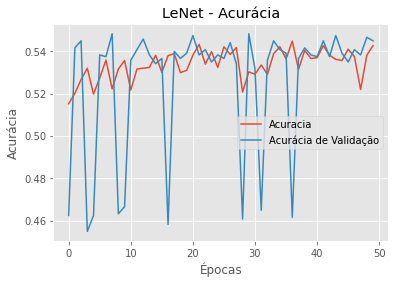

In [8]:
# Gráfico de Acurácia
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, epocas), h1["accuracy"], label="Acuracia")
plt.plot(np.arange(0, epocas), h1["val_accuracy"], label="Acurácia de Validação")
plt.title("LeNet N - Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.show()

In [9]:
prdLNt = lntClf.predict(conjTeste[0][0])
categorias = []
for i in conjTeste[0][1]:
    categorias.append(0 if i[0] > 0.0 else 1)
predLeNet = []
for i in prdLNt:
    predLeNet.append(0 if i[0] >= 0.5 else 1)
print(classification_report(categorias, predLeNet, target_names=["Não Covid", "Covid"]))

7/7 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

   Não Covid       0.47      1.00      0.63        93
       Covid       0.00      0.00      0.00       107

    accuracy                           0.47       200
   macro avg       0.23      0.50      0.32       200
weighted avg       0.22      0.47      0.30       200



c:\Users\Marcelo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Marcelo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Marcelo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

In [10]:
ga.geraHistorico("arquivos/arqLeNetNN"+str(epocas)+".csv", h1)
ga.geraPredicao("arquivos/arqPredLeNetNN"+str(tamanhoDoLote)+".csv", categorias, predLeNet)